# Graph Classification with DGL

Here we demonstrate how to use DGL to finish graph classification tasks. The dataset we use here is Tox21, a public database measuring toxicity of compounds.  The dataset contains qualitative toxicity measurements for 8014 compounds on 12 different targets, including nuclear receptors and stress response pathways. 

In [1]:
import dgl
from dgl.data.chem import Tox21
from dgl import model_zoo
from dgl.data.utils import split_dataset

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw,MolFromSmiles, MolToSmiles

In [3]:
import torch
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

## Load Dataset

This would take about one minute

In [4]:
dataset = Tox21()

Loading previously saved dgl graphs...


### Split dataset into train and val

In [5]:
trainset, valset = split_dataset(dataset, [0.8, 0.2], shuffle=True, random_state=42)

Each target label in a binary label. A common issue for multi-task prediction is that some datapoints are not labeled for all tasks. This is also the case for Tox21. In data pre-processing, we set non-existing labels to be 0 and corresponding mask value to be 0 too. The label below means NR-AhR has positive labels, and NR-Aromatase and NR-ER's labels are missing.

In [6]:
smile, graph, label, mask = dataset[0]
print(dataset.task_names)
print(smile)
print(label)
print(mask)

['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
CCOc1ccc2nc(S(N)(=O)=O)sc2c1
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.])


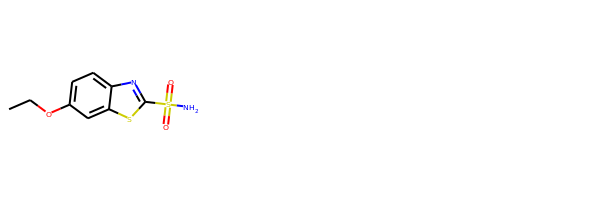

In [7]:
Draw.MolsToGridImage([MolFromSmiles(smile)])

Each atom can be considered as a node in graph, and the bond between them are the edges. We use [`CanonicalAtomFeaturizer`](https://docs.dgl.ai/generated/dgl.data.chem.CanonicalAtomFeaturizer.html#dgl.data.chem.CanonicalAtomFeaturizer), a fingerprint method to create feature for each node.

In [8]:
graph.ndata['h']

tensor([[1., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

## Prepare Dataloader

DGL could batch multiple small graphs together to accelerate the computation. Detail of batching can be found [here](https://docs.dgl.ai/tutorials/basics/4_batch.html).

<img src="https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/batch.png" width="500"/>

In [9]:
def collate_molgraphs_for_classification(data):
    """Batching a list of datapoints for dataloader in classification tasks."""
    smiles, graphs, labels, mask = map(list, zip(*data))
    bg = dgl.batch(graphs)
    labels = torch.stack(labels, dim=0)
    mask = torch.stack(mask, dim=0)
    return smiles, bg, labels, mask

train_loader = DataLoader(trainset, batch_size= 1024,
                          collate_fn=collate_molgraphs_for_classification)
val_loader = DataLoader(valset, batch_size= len(valset),
                        collate_fn=collate_molgraphs_for_classification)

## Prepare Model and Optimizer

Here we use a two layer Graph Convolutional Network to classify the graphs. Detailed source code can be found [here](https://github.com/dmlc/dgl/blob/master/python/dgl/model_zoo/chem/classifiers.py#L111).

In [10]:
model = model_zoo.chem.GCNClassifier(in_feats=74, gcn_hidden_feats=[128, 64], n_tasks=12).cuda()
loss_criterion = BCEWithLogitsLoss(reduction='none')
optimizer = Adam(model.parameters())
print(model)

GCNClassifier(
  (gnn_layers): ModuleList(
    (0): GCNLayer(
      (graph_conv): GraphConv(in=74, out=128, normalization=False, activation=<function relu at 0x7feb2f33dae8>)
      (dropout): Dropout(p=0.0)
      (res_connection): Linear(in_features=74, out_features=128, bias=True)
      (bn_layer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): GCNLayer(
      (graph_conv): GraphConv(in=128, out=64, normalization=False, activation=<function relu at 0x7feb2f33dae8>)
      (dropout): Dropout(p=0.0)
      (res_connection): Linear(in_features=128, out_features=64, bias=True)
      (bn_layer): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (weighted_sum_readout): WeightAndSum(
    (atom_weighting): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (soft_classifier): MLPBinaryClassifier(
    (predict): Sequential(
      (0): Dropout(p=0.0)
   

### Training

In [11]:
epochs = 50
model.train()
for i in tqdm(range(epochs)):
    for batch_id, batch_data in enumerate(train_loader):
        smiles, bg, labels, mask = batch_data
        atom_feats = bg.ndata.pop('h')
        atom_feats, labels, mask = atom_feats.to('cuda'), \
                                   labels.to('cuda'), \
                                   mask.to('cuda')
        logits = model(bg, atom_feats)
        # Mask non-existing labels
        loss = (loss_criterion(logits, labels) * (mask != 0).float()).mean()
        if batch_id % 20 == 0:
            tqdm.write("Loss: {}".format(loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/50 [00:00<?, ?it/s]

Loss: 0.5876147150993347


  2%|▏         | 1/50 [00:01<01:01,  1.26s/it]

Loss: 0.558411717414856


  4%|▍         | 2/50 [00:01<00:49,  1.03s/it]

Loss: 0.5425251722335815


  6%|▌         | 3/50 [00:02<00:40,  1.15it/s]

Loss: 0.5271397829055786


  8%|▊         | 4/50 [00:02<00:34,  1.32it/s]

Loss: 0.5093251466751099


 10%|█         | 5/50 [00:03<00:30,  1.48it/s]

Loss: 0.4875337481498718


 12%|█▏        | 6/50 [00:03<00:27,  1.61it/s]

Loss: 0.4610597491264343


 14%|█▍        | 7/50 [00:04<00:25,  1.71it/s]

Loss: 0.4311479926109314


 16%|█▌        | 8/50 [00:04<00:23,  1.79it/s]

Loss: 0.39738982915878296


 18%|█▊        | 9/50 [00:05<00:22,  1.85it/s]

Loss: 0.3623153567314148


 20%|██        | 10/50 [00:05<00:21,  1.85it/s]

Loss: 0.32660916447639465


 22%|██▏       | 11/50 [00:06<00:20,  1.90it/s]

Loss: 0.2927025854587555


 24%|██▍       | 12/50 [00:06<00:19,  1.94it/s]

Loss: 0.26108428835868835


 26%|██▌       | 13/50 [00:07<00:18,  1.97it/s]

Loss: 0.23346415162086487


 28%|██▊       | 14/50 [00:07<00:18,  1.99it/s]

Loss: 0.21096891164779663


 30%|███       | 15/50 [00:08<00:17,  2.01it/s]

Loss: 0.1922415941953659


 32%|███▏      | 16/50 [00:08<00:16,  2.01it/s]

Loss: 0.17746353149414062


 34%|███▍      | 17/50 [00:09<00:16,  1.97it/s]

Loss: 0.16814391314983368


 36%|███▌      | 18/50 [00:09<00:16,  1.93it/s]

Loss: 0.15853887796401978


 38%|███▊      | 19/50 [00:10<00:16,  1.92it/s]

Loss: 0.15198522806167603


 40%|████      | 20/50 [00:10<00:15,  1.92it/s]

Loss: 0.14573067426681519


 42%|████▏     | 21/50 [00:11<00:15,  1.91it/s]

Loss: 0.14299198985099792


 44%|████▍     | 22/50 [00:11<00:14,  1.90it/s]

Loss: 0.13752280175685883


 46%|████▌     | 23/50 [00:12<00:14,  1.92it/s]

Loss: 0.1353558599948883


 48%|████▊     | 24/50 [00:12<00:13,  1.95it/s]

Loss: 0.13188473880290985


 50%|█████     | 25/50 [00:13<00:12,  1.93it/s]

Loss: 0.12855902314186096


 52%|█████▏    | 26/50 [00:14<00:12,  1.95it/s]

Loss: 0.12634530663490295


 54%|█████▍    | 27/50 [00:14<00:11,  1.97it/s]

Loss: 0.12337897717952728


 56%|█████▌    | 28/50 [00:15<00:11,  1.98it/s]

Loss: 0.12214009463787079


 58%|█████▊    | 29/50 [00:15<00:10,  1.94it/s]

Loss: 0.11959465593099594


 60%|██████    | 30/50 [00:16<00:10,  1.96it/s]

Loss: 0.11824457347393036


 62%|██████▏   | 31/50 [00:16<00:09,  1.97it/s]

Loss: 0.11686988919973373


 64%|██████▍   | 32/50 [00:17<00:09,  1.99it/s]

Loss: 0.11635354161262512


 66%|██████▌   | 33/50 [00:17<00:08,  2.00it/s]

Loss: 0.12135326862335205


 68%|██████▊   | 34/50 [00:18<00:07,  2.01it/s]

Loss: 0.11697719991207123


 70%|███████   | 35/50 [00:18<00:08,  1.85it/s]

Loss: 0.1135300025343895


 72%|███████▏  | 36/50 [00:19<00:07,  1.90it/s]

Loss: 0.11862069368362427


 74%|███████▍  | 37/50 [00:19<00:06,  1.93it/s]

Loss: 0.11016317456960678


 76%|███████▌  | 38/50 [00:20<00:06,  1.95it/s]

Loss: 0.10646724700927734


 78%|███████▊  | 39/50 [00:20<00:05,  1.96it/s]

Loss: 0.10522463172674179


 80%|████████  | 40/50 [00:21<00:05,  1.98it/s]

Loss: 0.10247699916362762


 82%|████████▏ | 41/50 [00:21<00:04,  1.99it/s]

Loss: 0.10324057191610336


 84%|████████▍ | 42/50 [00:22<00:03,  2.00it/s]

Loss: 0.10076790302991867


 86%|████████▌ | 43/50 [00:22<00:03,  2.00it/s]

Loss: 0.09709861129522324


 88%|████████▊ | 44/50 [00:23<00:02,  2.01it/s]

Loss: 0.09726320207118988


 90%|█████████ | 45/50 [00:23<00:02,  2.01it/s]

Loss: 0.09650824964046478


 92%|█████████▏| 46/50 [00:24<00:01,  2.01it/s]

Loss: 0.09565724432468414


 94%|█████████▍| 47/50 [00:24<00:01,  2.01it/s]

Loss: 0.09427398443222046


 96%|█████████▌| 48/50 [00:25<00:00,  2.02it/s]

Loss: 0.09360237419605255


 98%|█████████▊| 49/50 [00:25<00:00,  2.01it/s]

Loss: 0.09596117585897446


100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


### Inference

In [12]:
model.eval()
with torch.no_grad():
    for batch_id, batch_data in enumerate(tqdm(val_loader)):
        smiles, bg, labels, mask = batch_data
        atom_feats = bg.ndata.pop('h')
        atom_feats, labels, mask = atom_feats.to('cuda'), \
                                   labels.to('cuda'), \
                                   mask.to('cuda')
        logits = model(bg, atom_feats)
        accuracy_overall_tasks = (((logits>0)==labels.byte()).float()*mask).sum()/mask.sum()
        print(accuracy_overall_tasks)

100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

tensor(0.9320, device='cuda:0')


We acheived a pretty high accuracy. However, this dataset's labels are imbalanced, which means most labels could be negative. Therefore it would be unfair to evaluate result with accuracy score. A more detailed analysis of this task could be found at our [model zoo](https://github.com/dmlc/dgl/tree/master/examples/pytorch/model_zoo/chem/property_prediction).